![](https://raw.githubusercontent.com/unm-escape/escape2022/main/header2.png)

<h1 style="text-align:center; color:#3333ff;">Plotting seismic reflection data and picking arrivals</h1>
<br>
<div style="text-align:center; font-size:16px">
    Earth and Planetary Sciences,<br>
    University of New Mexico<br>
    <br>
    August 17, 2022
</div>

---
**Tutorial Outline:**
1. Reading SEG-Y data from file<br>
2. Updating header info<br>
3. Applying simple amplitude attenuation correction<br>
4. Picking arrivals<br>
---
**Dependencies:** Obspy, Numpy, Matplotlib and the Utils script

---

<font size="4.5">**1. Reading SEG-Y data from file**</font><br>

Having looked at earthquake seismograms, the goal of this exercise is to quickly look at seismic reflection data while leveraging the Obspy and Matplotlib skills you acquired in previous lectures.

There are more robust python and non-python open-source frameworks for processing seismic reflection data. I recommend [Seismic Unix](https://wiki.seismic-unix.org/doku.php) and [Madagascar](https://reproducibility.org/wiki/Main_Page).

<font size="4.5">Importing required modules:</font><br>

The Utils module is a custom file containing several functions we will need to handle the SEG-Y files. Modules allow for breaking large programs into small manageable files and makes code reusable. 

Let's start by importing required modules.

In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from obspy import Stream, read
from utils import plot_segy, pick_segy, plot_segy_picks, gain

Read the SEG-Y data into a [Stream object](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html#obspy.core.stream.Stream) by supplying obspy [read function](https://docs.obspy.org/packages/autogen/obspy.core.stream.read.html) with the path to the SEG-Y file on your computer.

The dataset we are using in this exercise, known as the OZ-25 dataset, is widely used in the geophysics community (see Yilmaz (2001), Chen et al. (2015) and Yarham et al. (2006)). The data is available at the [Seismic Unix website](https://wiki.seismic-unix.org/tutorials:data) and the [madagascar website](https://www.reproducibility.org/wiki/Main_Page).

In [2]:
stream = read('./data/ozdata_25.segy', format='SEGY',check_compression=False,unpack_trace_headers=True)
print(stream)

96 Trace(s) in Stream:

Seq. No. in line:    1 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:04.198000Z | 500.0 Hz, 2100 samples
...
(94 other traces)
...
Seq. No. in line:   96 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:04.198000Z | 500.0 Hz, 2100 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


Let's grab the first trace object and view a summary its metadata.

In [3]:
tr = stream[0]
print(tr)

Seq. No. in line:    1 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:04.198000Z | 500.0 Hz, 2100 samples


Let's view the actual trace data

In [4]:
print(tr.data)

[13794.199 12425.504 13239.254 ...     0.        0.        0.   ]


---
<font size="4.5">**2. Updating header info**</font><br>

The data is a common shot gather with a time sampling rate of 0.002s and receiver spacing of 0.05 km (50 m). The shot location is at the center of the array. 

Key headers of the OZ-25 data aren't populated, so let's update the receiver location, source location and the offset assuming a 2-D line.

In [5]:
sx = 2350 # source x coordinate
gx = -0.05*1000 # Initialize receiver x coordinate at -50 m

# Loop throught the stream
for tr in stream:
    gx += 0.05*1000
    tr.stats.segy.trace_header.group_coordinate_x = gx
    tr.stats.segy.trace_header.source_coordinate_x = sx
    tr.stats.segy.trace_header.distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group = gx-sx
print("Update done!")

Update done!


---
<font size="4.5">**3. Applying simple amplitude attenuation correction**</font><br>

Seismic amplitude is the magnitude of the wiggles in a seismic record. The amplitude is the experession of the energy in a seismic wave as a function of space, time and frequency (Zhou, 2014). The amplitude of seismic data depends on the source, receiver, and the medium in which the waves are propagating.

In active source reflection seismology, the effect of the source and the receivers is anticipated and minimized. However, seismic attenuation due to media is typically addressed during processing. Seismic wave attenuation due to the media of propagation includes transmission loss, absorption and spherical spreading (Shearer, 2009).

Plot the raw shot gather with the plot_segy function:

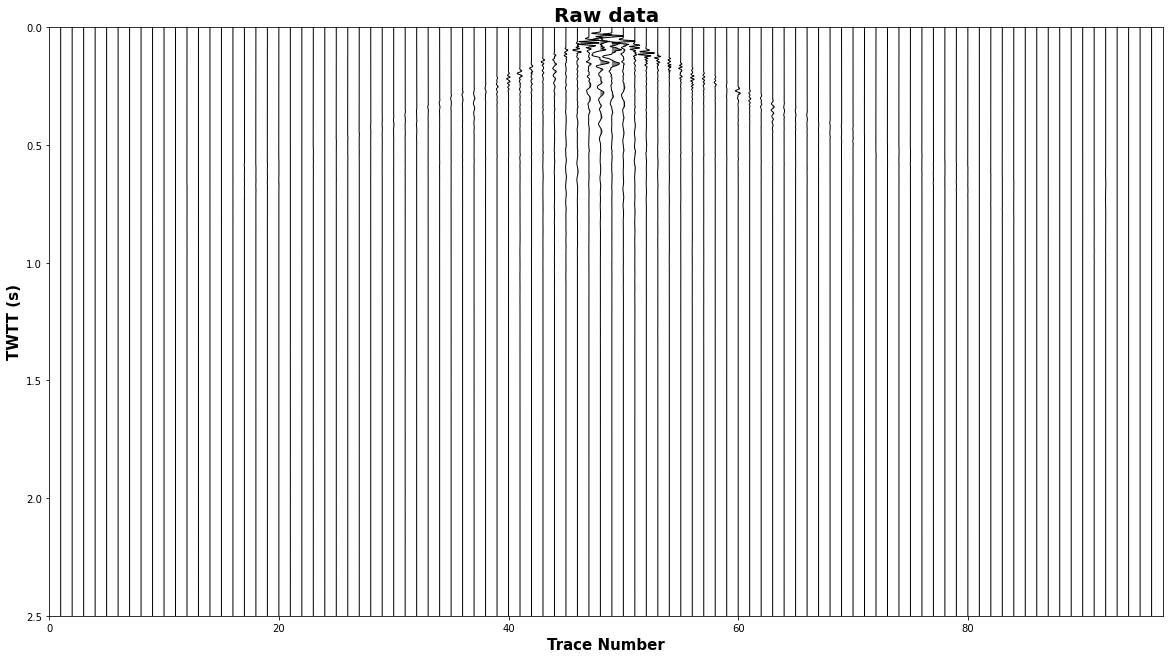

In [6]:
## Plot raw traces
startTime = 0.0
endTime = 2.5
plot_segy(stream, normalizeTraces=False, normalizeGlobal=True, 
          scale=1, title='Raw data', tstart=startTime, tend=endTime, saveFigure=False)

---
**Gain** is the amplitude correction applied to the seismic data. There are data-independent and data-dependent amplitude correction methods. In data-independent techniques, the scaling function is not derived from the amplitude information in the data.

An example of a data-independent method is the $t^{2}$ method where each trace's data is multiplied by the square of the two-way travel time (Yilmaz, 2001).

Use the gain function from the Util module to apply the $t^{2}$ gain:

---

In [7]:
gainedStream = gain(stream, normalizeTraces=True)

Use the plot_segy function from the Util module to plot the $t^{2}$ gained dataset.

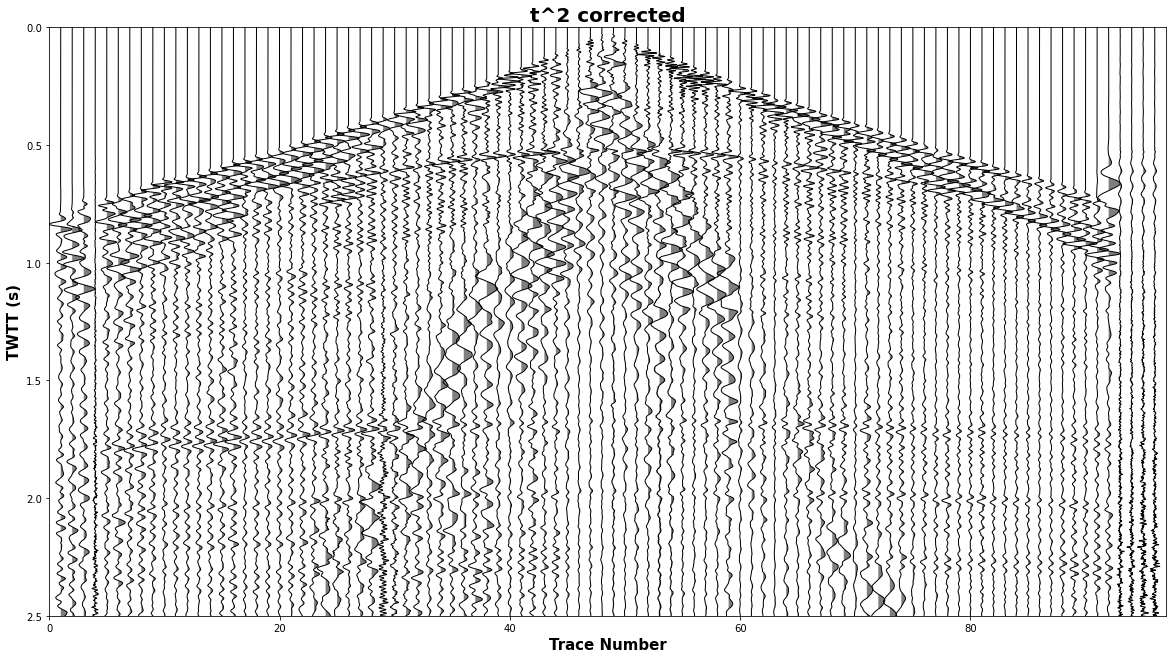

In [8]:
startTime = 0.0
endTime = 2.5
plot_segy(gainedStream, normalizeTraces=False, normalizeGlobal=False, 
          scale=1, title='t^2 corrected', tstart=startTime, tend=endTime, saveFigure=False)

---
<font size="4.5">**4. Picking arrivals**</font><br>
<br>

![](https://raw.githubusercontent.com/unm-escape/escape2022/main/day08_Aug17/schematic.png)

Now we identify the phases and pick the arrivals.

First let's isolate one half of the raw and gained shot gather.

In [9]:
half_offset = Stream()
for tr in stream:
    if tr.stats.segy.trace_header.distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group >= 0:
        half_offset += tr
        
half_offset_gained = Stream()
for tr in gainedStream:
    if tr.stats.segy.trace_header.distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group >= 0:
        half_offset_gained += tr

Pick the direct wave.

In [10]:
## Pick first arrival
startTime = 0.0
endTime = 1.0
dw_trc_nums, dw_picks, dw_offsets = pick_segy(half_offset, normalizeTraces=True, normalizeGlobal=False, scale=1, 
                                          title=None, tstart=startTime, tend=endTime, 
                                          saveFigure=True)

Success! Picks Ready.


---
Plot the picks on the half-offset gathers

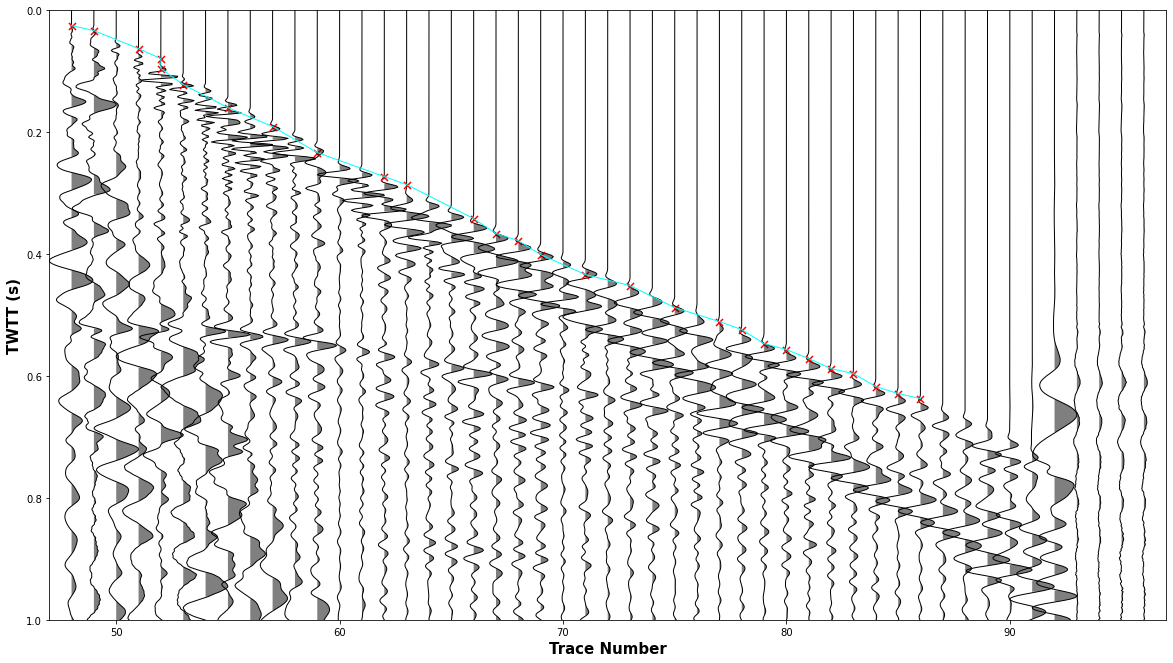

In [11]:
## Plot picks
%matplotlib inline
plot_segy_picks(half_offset_gained, normalizeTraces=True, normalizeGlobal=False, scale=1, title=None, 
                tstart=0, tend=1, picksX=dw_trc_nums, picksY=dw_picks, saveFigure=True)

Create a T-X plot with your picks.

In [13]:
print(dw_offsets)
print(' ')
print(dw_picks)

[0.0, 50.0, 150.0, 200.0, 200.0, 250.0, 350.0, 450.0, 550.0, 700.0, 750.0, 900.0, 950.0, 1000.0, 1050.0, 1150.0, 1250.0, 1350.0, 1450.0, 1500.0, 1550.0, 1600.0, 1650.0, 1700.0, 1750.0, 1800.0, 1850.0, 1900.0]
 
[0.02494257 0.03314736 0.06268461 0.07909419 0.09550377 0.12175911
 0.15950115 0.19067936 0.23334427 0.27272727 0.28585494 0.34164752
 0.3662619  0.37774861 0.40072202 0.43354119 0.45159173 0.48769281
 0.51066623 0.5237939  0.54676731 0.55661306 0.57138169 0.58779127
 0.59599606 0.61732852 0.62881523 0.63702002]


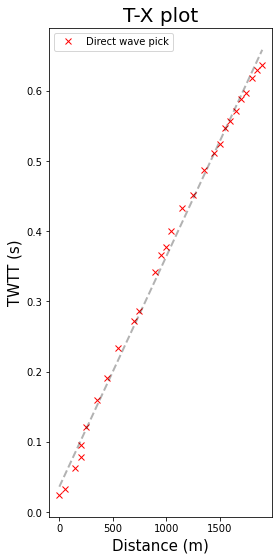

In [14]:
#m, b = np.polyfit(offsets, time_picks,1)
coeffs = np.polyfit(dw_offsets, dw_picks,1)
# Create the poly1d_fn function which takes in x and returns an estimate for y
poly1d_fn = np.poly1d(coeffs)

fig, axs = plt.subplots(figsize=(4,9))
plt.axis('off')
ax = fig.add_subplot()

#ax.plot(offsets, time_picks, color='b', lw=1.0, zorder=1)
#plt.scatter(offsets, time_picks, marker='x', color='r', s=50)

#ax.plot(offsets, time_picks, 'rx', offsets, poly1d_fn(offsets), '--k')
ax.plot(dw_offsets, dw_picks, 'rx', lw=1.0, zorder=1, label='Direct wave pick')
ax.plot(dw_offsets, poly1d_fn(dw_offsets), '--k', lw=2.0, zorder=2, alpha=0.3)

ax.set_xlabel('Distance (m)', fontsize=15)
ax.set_ylabel('TWTT (s)', fontsize=15)
#ax.text(offsets[round(len(offsets)/2)], time_picks[round(len(time_picks)/2)], str(round(1/m,2))+' m/s', fontsize=15)
plt.title('T-X plot', fontsize=20)
#plt.gca().invert_yaxis()
plt.legend()
plt.show()

Use Numpy's polyfit function to calculate $V_{0}$

In [15]:
# y = mx + b
# y = slope*x + y-intercept
m, b = np.polyfit(dw_offsets, dw_picks, 1)
#print(1/m)
#print(b)
print('V\N{SUBSCRIPT ZERO} = ' + str(round(1/m, 2)) + ' m/s')

V₀ = 3054.35 m/s


Use the pick_segy function to pick reflected wave

In [20]:
## Pick reflected wave
startTime = 0.0
endTime = 1.0
rw_trc_nums, rw_picks, rw_offsets = pick_segy(half_offset, normalizeTraces=True, normalizeGlobal=False, scale=1, 
                                          title=None, tstart=startTime, tend=endTime, 
                                          saveFigure=False)

Success! Picks Ready.


Plot reflected wave picks on the half-offset gathers

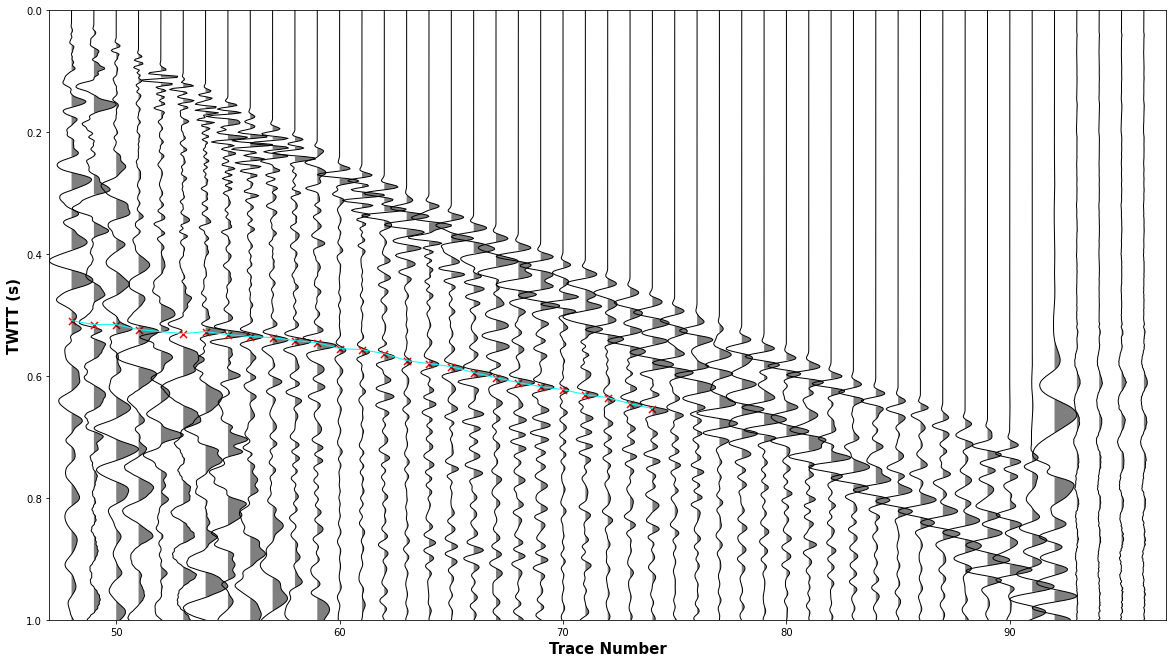

In [21]:
## Plot picks
%matplotlib inline
plot_segy_picks(half_offset_gained, normalizeTraces=True, normalizeGlobal=False, scale=1, title=None, 
                tstart=0, tend=1, picksX=rw_trc_nums, picksY=rw_picks, saveFigure=False)

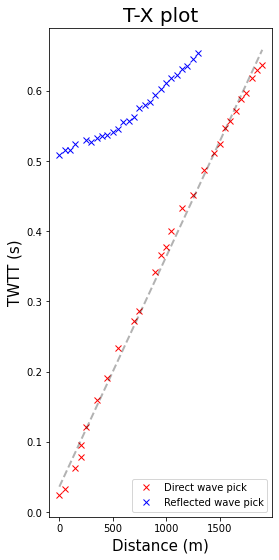

In [22]:
%matplotlib inline
fig, axs = plt.subplots(figsize=(4,9))
plt.axis('off')
ax = fig.add_subplot()

ax.plot(dw_offsets, dw_picks, 'rx', lw=1.0, zorder=1, label='Direct wave pick')
ax.plot(dw_offsets, poly1d_fn(dw_offsets), '--k', lw=2.0, zorder=2, alpha=0.3)
ax.plot(rw_offsets, rw_picks, 'bx', lw=1.0, zorder=3, label='Reflected wave pick')

ax.set_xlabel('Distance (m)', fontsize=15)
ax.set_ylabel('TWTT (s)', fontsize=15)
#ax.text(offsets[round(len(offsets)/2)], time_picks[round(len(time_picks)/2)], str(round(1/m,2))+' m/s', fontsize=15)
plt.title('T-X plot', fontsize=20)
plt.legend()
#plt.gca().invert_yaxis()
plt.show()

Create a $T^{2}$-$X^{2}$ plot of reflected picks.

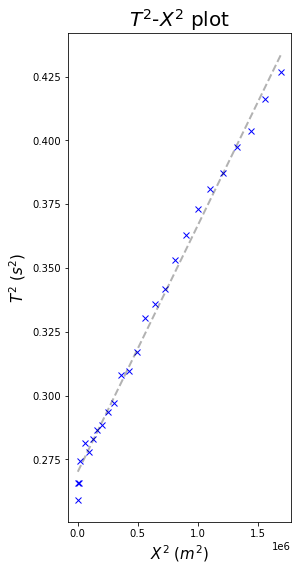

In [23]:
t_squared = np.square(rw_picks)
x_squared = np.square(rw_offsets)
#m, b = np.polyfit(offsets, time_picks,1)
rw_coeffs = np.polyfit(x_squared, t_squared, 1)
# Create the poly1d_fn function which takes in x and returns an estimate for y
rw_poly1d_fn = np.poly1d(rw_coeffs)

%matplotlib inline
fig, axs = plt.subplots(figsize=(4,9))
plt.axis('off')
ax = fig.add_subplot()
ax.plot(x_squared, t_squared, 'bx', lw=1.0, zorder=1)
ax.plot(x_squared, rw_poly1d_fn(x_squared), '--k', lw=2.0, zorder=2, alpha=0.3)
ax.set_xlabel('$X^{2}$ ($m^{2}$)', fontsize=15)
ax.set_ylabel('$T^{2}$ ($s^{2}$)', fontsize=15)
plt.title('$T^{2}$-$X^{2}$ plot', fontsize=20)
plt.show()

In [24]:
# y = mx + b
# y = slope*x + y-intercept
m, b = np.polyfit(x_squared, t_squared, 1)
stackVel = np.sqrt(1/m)
print('Stacking velocity = ' + str(round(stackVel, 2)) + ' m/s')

Stacking velocity = 3216.66 m/s


---
### References
* Chen, Y., Jiao, S., Ma, J., Chen, H., Zhou, Y., & Gan, S. (2015). Ground-roll noise attenuation using a simple and effective approach based on local band-limited orthogonalization. IEEE Geoscience and Remote Sensing Letters, 12(11), 2316-2320.


* Shearer, P. M. (2009). Introduction to Seismology. Cambridge University Press.


* Yarham, C., Boeniger, U., & Herrmann, F. (2006, October). Curvelet-based ground roll removal. In 2006 SEG Annual Meeting. OnePetro.


* Yilmaz, Ö. (2001). Seismic data analysis: Processing, inversion, and interpretation of seismic data, Third Ed., S. M. Doherty (Editor), Vol. I, Society of Exploration Geophysicists, Tulsa, Oklahoma.


* Zhou, Hua-Wei. Practical seismic data analysis. Cambridge University Press.
